# SimCLR and Transfer Learning

We train a SimCLR base model on a meta-dataset, then transfer it to a CWRU few-shot dataset.

In [1]:
# %xmode minimal

from pathlib import Path
import os

os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"
# os.environ["KERAS_BACKEND"] = "tensorflow"

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

# Turn off logging for TF
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow_datasets as tfds
tf.get_logger().setLevel(logging.ERROR)

# import librosa
# import librosa.display
# from IPython.display import Audio

import numpy as np
from matplotlib import pyplot as plt

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import keras
from keras import layers, models, ops, losses, metrics
# from keras.applications import resnet, vgg16

# tf.config.experimental_run_functions_eagerly(True)
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [2]:
import dpmhm
# dpmhm.datasets.get_dataset_list()

from dpmhm.datasets import preprocessing, transformer, feature, utils, spectral_window_pipeline, spectral_pipeline
from dpmhm.models import simclr

workdir = Path(os.path.expanduser("~/tmp/dpmhm/SimCLR-fewshot"))
os.makedirs(workdir, exist_ok=True)

# dpmhm.datasets.query_parameters('Paderborn')

In [3]:
def _pipeline(ds_name:str, sr:int, *, 
              split:str='all', channels:list[str]=[], keys:list[str]=[],
              nf:int=512, tw:float=None, hs:float=None, ws:int=128, 
              normalize:bool=True,
              labels:bool=False):
    """Simple pipeline of data extraction for sliding window.
    
    Args:
        ds_name: name of dataset
        sr: original sampling rate
        split: active split of dataset
        channels: list of active channels
        nf: number of frequency bins
        tw: time window in second for spectrogram
        hs: hop size in window for spectrogram
        ws: sliding window size in frequency and time axis
    """        
    if tw is None:
        tw = nf / sr
    if hs is None:
        hs = tw / 4
        
    _func = lambda x, sr: feature.spectral_features(
        x, sr, 'spectrogram',
        time_window=tw, 
        hop_step=hs, 
        n_fft=nf,
        normalize=normalize, to_db=True)[0]
    
    compactor_kwargs = dict(
        resampling_rate=None,
        channels=channels,
        keys=keys,
        split_channel=True
    )
    
    # wl = ws * hs  # time length of spectrogram patches
    window_kwargs = dict(
        window_size=(ws, ws), # full bandwidth
        hop_size=(ws//2, ws//2),
    )

    extractor, compactor, _ = dpmhm.datasets.spectral_pipeline(
        ds_name, 
        split=split,
        spectral_feature=_func,
        compactor_kwargs=compactor_kwargs,
        shuffle_files=True        
    )

    window = transformer.WindowSlider(
        extractor.dataset,
        **window_kwargs
        )
    dw = window.dataset

    # dw = dpmhm.datasets.spectral_window_pipeline(
    #     ds_name, 
    #     split=split,
    #     spectral_feature=_func,
    #     compactor_kwargs=compactor_kwargs,
    #     window_kwargs=window_kwargs,
    #     shuffle_files=True        
    # )

    if labels:
        return dw, compactor.full_label_dict
    else:
        return dw

## Build a meta-dataset

First we load several datasets and extract spectrogram patches of fixed dimension `(128,128)`. This dimension is large enough to accomodate the random crop of shape `(64,64)` that will be created later by spec-augmentation. Also we skip the resampling step which will considerable slow down the loading of datasets, and take randomly the first `Nmax` elements to reduce the size of the final dataset.

In [4]:
ds_all = {}

nf = 1024  # number of frequency bins
Nmax = 2500  # maximum number of elements per dataset
shuffle_size = 100000

In [5]:
foo = _pipeline('DIRG', 51200, split='variation', channels=[], nf=nf)
# ds_all['DIRG'] = foo
ds_all['DIRG'] = utils.restore_cardinality(foo.shuffle(shuffle_size).take(Nmax))

foo = _pipeline('Paderborn', 64000, split='healthy[:10%]+artificial[:10%]', channels=['vibration'], nf=nf)
# ds_all['Paderborn'] = foo
ds_all['Paderborn'] = utils.restore_cardinality(foo.shuffle(shuffle_size).take(Nmax))

foo = _pipeline('Ottawa', 200000, split='all', channels=[], nf=nf)
# ds_all['Ottawa'] = foo
ds_all['Ottawa'] = utils.restore_cardinality(foo.shuffle(shuffle_size).take(Nmax))

foo = _pipeline('Phmap2021', 10544, split='train[:50%]', channels=[], nf=nf)
# ds_all['Phmap2021'] = foo
ds_all['Phmap2021'] = utils.restore_cardinality(foo.shuffle(shuffle_size).take(Nmax))

# eles = list(foo.take(10).as_numpy_iterator())

In [6]:
ds_size = 0
for k, foo in ds_all.items():
    print(k, int(foo.cardinality()))
    ds_size += int(foo.cardinality())

DIRG 2500
Paderborn 2500
Ottawa 2500
Phmap2021 2500


In [7]:
# Serialization for better performance.
# Note that this should be done before the random augmentation.

ds1, ds2, ds3, ds4 = ds_all['DIRG'], ds_all['Paderborn'], ds_all['Ottawa'], ds_all['Phmap2021']

ds0 = ds1.concatenate(ds2).concatenate(ds3).concatenate(ds4)

ds0.save(str(workdir/'simclr_dataset'))
ds0 = tf.data.Dataset.load(str(workdir/'simclr_dataset'))

In [8]:
window_shape = (64, 64)

dst = transformer.SpecAugmentTwins(
    ds0,
    output_shape=window_shape,
    crop_kwargs={'prob':0.5},
    flip_kwargs={'axis':-1, 'prob':0.5},
    blur_kwargs={'sigma':1., 'prob':0.5},
    fade_kwargs={'prob':0},
).dataset.map(
    lambda y1, y2: (tf.transpose(y1, perm=(1,2,0)), tf.transpose(y2, perm=(1,2,0)))  # to channel-last
)

ds = tf.data.Dataset.zip(dst, utils.constant_dataset())

# ds = utils.restore_cardinality(ds, ds_size)
input_shape = ds.element_spec[0][0].shape

ds.element_spec

((TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None)),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [15]:
# # Serialization may disable the random augmentation

# ds.save(str(workdir/'simclr_dataset'))
# ds = tf.data.Dataset.load(str(workdir/'simclr_dataset'))

## Base SimCLR model

We train a base SimCLR model on the meta-dataset.

In [9]:
batch_size = 256

ds_train = ds.shuffle(ds_size, reshuffle_each_iteration=True)\
    .repeat()\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
# ds_val = ds_split['val'].batch(batch_size, drop_remainder=True)
# ds_test = ds_split['test'].batch(1, drop_remainder=True)

ds_train.element_spec

((TensorSpec(shape=(256, 64, 64, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(256, 64, 64, 1), dtype=tf.float32, name=None)),
 TensorSpec(shape=(256,), dtype=tf.float32, name=None))

In [33]:
# encoder_kwargs = dict(include_top=False, weights='imagenet', pooling='avg')
# encoder_kwargs = dict(include_top=False, weights=None, pooling='avg')
# model = dpmhm.models.simclr.SimCLR(input_shape, name='VGG16', tau=0.1, **encoder_kwargs)

model = dpmhm.models.simclr.SimCLR(input_shape, name='CNN', tau=0.1)

model._encoder.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "sim_clr_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ ?                      │     1,142,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projector (Sequential)          │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,272 (4.36 MB)

 Trainable params: 1,141,824 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
hh = model.fit(ds_train,
               # validation_data=ds_val,
               steps_per_epoch=ds_size // batch_size,
               epochs=10)

model.save(workdir/'simclr_base.keras')

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - loss: 3045046.2500
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 2810577.0000
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - loss: 2746814.2500
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - loss: 2681460.5000
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 2583657.2500
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - loss: 2548780.0000
Epoch 7/10
30/39 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - loss: 2486216.7500

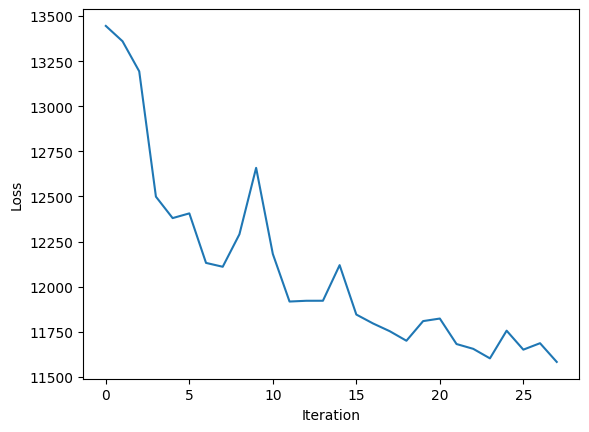

In [26]:
fig, ax = plt.subplots()
ax.plot(model.history.history['loss'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
fig.savefig(workdir/'convergence.png')

From the trained SimCLR model, we extract the feature transformation part which includes the base encoder and the first two dense layers of the projection head. 

In [30]:
x = layers.Input(input_shape)

# same same
# _proj = models.Model(inputs=model._projector.inputs, outputs=model._projector.layers[3].output)
_proj = models.Model(inputs=model._projector.layers[0].input, outputs=model._projector.layers[3].output)

# _proj.summary()  # shows a concrete value for batch

f = _proj(model._encoder(x))

model_feature = models.Model(inputs=x, outputs=f, name='SimCLR_feature')

model_feature.summary()  # shows `None` for batch

model_feature.save(str(workdir/'simclr_feature.keras'))

Model: "SimCLR_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 512)            │    14,714,694 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 256)            │     3,166,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,881,158 (68.21 MB)

 Trainable params: 17,872,966 (68.18 MB)

 Non-trainable params: 8,192 (32.00 KB)

TypeError: 'NoneType' object is not callable

## Transfer Learning

In [47]:
foo, full_labels_dict = _pipeline(
    'CWRU', 12000, split='all', 
    channels=[], keys=['FaultLocation', 'FaultComponent', 'FaultSize'], 
    nf=nf, ws=64, labels=True
)

labels = list(full_labels_dict.keys())  
n_classes = len(labels) + 1

In [48]:
preproc = preprocessing.get_mapping_supervised(labels)

dw = utils.restore_cardinality(
    utils.restore_shape(
        foo.map(preproc, num_parallel_calls=tf.data.AUTOTUNE),
        key=0
    )
)

dw_size = int(dw.cardinality())

### Supervised fine tuning

We add a classification head to the feature transformation network and fine tune the model on some new data.

In [49]:
splits = {'train':0.7, 'val':0.2, 'test':0.1}
batch_size = 32

dw_split = utils.split_dataset(
    dw, splits, 
    ds_size=dw_size, 
    # labels=np.arange(n_classes)
)

dw_train = dw_split['train']\
    .shuffle(dw_size, reshuffle_each_iteration=True)\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
dw_val = dw_split['val'].batch(batch_size, drop_remainder=True)
dw_test = dw_split['test'].batch(batch_size, drop_remainder=True)

The classification head here is a simple MLP. The weights of the feature transformation network are frozen for the training.

In [50]:
model_feature.trainable = False

class_head = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation=None) # nb labels
], name='Classification_head')

x = layers.Input(input_shape)

model_fine = models.Model(inputs=x, outputs=class_head(model_feature(x)))

model_fine.compile(
    optimizer=keras.optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [51]:
hh = model_fine.fit(
    dw_train,
    validation_data=dw_val,
    epochs=100
)

RuntimeError: Unable to automatically build the model. Please build it yourself before calling fit/evaluate/predict. A model is 'built' when its variables have been created and its `self.built` attribute is True. Usually, calling the model on a batch of data is the right way to build it.
Exception encountered:
'Exception encountered when calling Conv2D.call().

[1m'NoneType' object is not callable[0m

Arguments received by Conv2D.call():
  • inputs=jnp.ndarray(shape=(32, 64, 64, 1), dtype=float32)'

In [35]:
model_fine.evaluate(dw_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - loss: 2.8925 - sparse_categorical_accuracy: 0.1254


[2.8936824798583984, 0.140625]

#### Fine tuning

In [36]:
model_feature.trainable = True

model_fine.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [37]:
hh = model_fine.fit(
    dw_train,
    validation_data=dw_val,
    epochs=2
)

Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 4.6855 - sparse_categorical_accuracy: 0.0234 - val_loss: 3.5561 - val_sparse_categorical_accuracy: 0.0368
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 4.5819 - sparse_categorical_accuracy: 0.0189 - val_loss: 3.8871 - val_sparse_categorical_accuracy: 0.0402


In [38]:
model_fine.evaluate(dw_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - loss: 3.7828 - sparse_categorical_accuracy: 0.0330


[3.748819589614868, 0.0357142873108387]

# EOF

### Few-shot learning

In few-shot learning the number of new data per category is limited. We can prepare the data for few-shot learning by splitting separately data of each category.

However for unknown reasons, the performance of the few-shot split seems to be very low compared to the normal split.

In [ ]:
splits = {'train':0.2, 'val':0.7, 'test':0.1}
batch_size = 64

n_classes = len(labels) + 1

In [ ]:
# Only for demonstration, here we apply the preprocessing after the split.
dw_split = utils.split_dataset(
    dw, splits, 
    labels=labels
)

for k, dv in dw_split.items():
    dv.save(str(workdir/f'fs_split_{k}'))

In [94]:
dw_split = {}
for k in splits.keys():
    dw_split[k] = tf.data.Dataset.load(str(workdir/f'fs_split_{k}'))

In [116]:
dw_train = dw_split['train']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(1000, reshuffle_each_iteration=True)\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
dw_val = dw_split['val']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size, drop_remainder=True)
dw_test = dw_split['test']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size, drop_remainder=True)

In [118]:
%time eles = list(dw_train.take(10))

CPU times: user 172 ms, sys: 13.4 ms, total: 185 ms
Wall time: 58.7 ms


2024-06-18 23:51:57.085419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
eles[0][0]

In [ ]:
model_feature(eles[0][0])

In [101]:
model_feature.trainable = False

class_head = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(n_classes) # nb labels
], name='Classification_head')

x = layers.Input(input_shape)

model_fs = models.Model(inputs=x, outputs=class_head(model_feature(x)))

model_fs.compile(
    optimizer=keras.optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [102]:
hh = model_fs.fit(
    dw_train,
    validation_data=dw_val,
    epochs=10
)

RuntimeError: Unable to automatically build the model. Please build it yourself before calling fit/evaluate/predict. A model is 'built' when its variables have been created and its `self.built` attribute is True. Usually, calling the model on a batch of data is the right way to build it.
Exception encountered:
'Exception encountered when calling Conv2D.call().

[1m'NoneType' object is not callable[0m

Arguments received by Conv2D.call():
  • inputs=jnp.ndarray(shape=(64, 70, 70, 3), dtype=float32)'

In [ ]:
model_fs.evaluate(dw_test)

2024-06-18 23:41:21.174297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:22.954204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:24.714093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:26.471666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:28.231720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:30.062777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:31.896178: W tensorflow/core/framework/local_rendezvous.cc:404] L

# EOF

In [11]:
window_shape = (64, 64)
ds_window = {}

for k, ds in ds_all.items():
    ds_window[k] = transformer.SpecAugmentTwins(
        ds,
        output_shape=window_shape,
        crop_kwargs={'prob':1},
        flip_kwargs={'axis':-1, 'prob':0.5},
        blur_kwargs={'sigma':1., 'prob':0.5},
        fade_kwargs={'prob':0},
    ).dataset.map(
        lambda y1, y2: (tf.transpose(y1, perm=(1,2,0)), tf.transpose(y2, perm=(1,2,0)))  # to channel-last
    )

# for k, ds in ds_all.items():
#     ds_window[k] = transformer.SpecAugment(
#         ds,
#         output_shape=window_shape,
#         crop_kwargs={'prob':0.5},
#         flip_kwargs={'axis':-1, 'prob':0.5},
#         blur_kwargs={'sigma':1., 'prob':0.5},
#         fade_kwargs={'prob':0},
#     ).dataset.map(lambda x: x['feature'])

In [16]:
ds1, ds2, ds3, ds4 = ds_window['DIRG'], ds_window['Paderborn'], ds_window['Ottawa'], ds_window['Phmap2021']

ds0 = ds1.concatenate(ds2).concatenate(ds3).concatenate(ds4)
ds = tf.data.Dataset.zip(ds0, utils.constant_dataset())
# ds, input_shape = utils.twins_dataset_ssl(ds0, stack=False, fake_label=True)

ds = utils.restore_cardinality(ds, ds_size)
input_shape = ds.element_spec[0][0].shape

ds.element_spec

((TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None)),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [ ]:
# dp = tfds.load('Phmap2021', split='all')

rsr = 10544
nf = 512
tw = nf/rsr
hs = tw/4

_func = lambda x, sr: feature.spectral_features(
    x, sr, 'spectrogram',
    time_window=tw, hop_step=hs, 
    n_fft=nf,
    normalize=True, to_db=True)[0]

compactor_kwargs = dict(
    resampling_rate=rsr,
    channels=[],
    split_channel=True
)

extractor, compactor, n = dpmhm.datasets.spectral_pipeline(
    'Phmap2021', _func, 
    compactor_kwargs=compactor_kwargs
)

wl = 1.
ws = int(wl/hs)  # time length of spectrogram patches of 1s
window_kwargs = dict(
    window_size=ws, # full bandwidth
    hop_size=ws//2,
)

window = transformer.WindowSlider(
    extractor.dataset,
    **window_kwargs
    )



dp = compactor.dataset

for x in dp.take(100).as_numpy_iterator():
    print(x['signal'].shape[1]/10544, x['signal'].shape)

dp = extractor.dataset

for x in dp.take(100).as_numpy_iterator():
    print(x['feature'].shape)

dp = window.dataset

for x in dp.take(100).as_numpy_iterator():
    print(x['feature'].shape)